Martín Amado - 19020
Juan Pablo Pineda - 19087
Laura Tamath - 19365

referencia para análisis de datos: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python#4.-Missing-data

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import statsmodels.stats.diagnostic as diag
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn import metrics
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
import sklearn.preprocessing
import random
import graphviz
## import pyclustertend 
import matplotlib.cm as cm
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

from sklearn.decomposition import PCA
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo 

ModuleNotFoundError: No module named 'factor_analyzer'

## Análisis  exploratorio

In [3]:
data = pd.read_csv('./train.csv', encoding = "latin1")
file = open('cuantitativas.txt', 'r')
quant= file.read().splitlines()
file = open('cualitativas.txt', 'r')
quali= file.read().splitlines()

## Descripcion de los datos

In [6]:
#Variables cuantitativas
data[quant].describe()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
count,1201.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,...,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,180921.195890
std,24.284752,9981.264932,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,...,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,79442.502883
min,21.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000
25%,59.000000,7553.500000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,...,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129975.000000
50%,69.000000,9478.500000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,...,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163000.000000
75%,80.000000,11601.500000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,...,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,214000.000000
max,313.000000,215245.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,...,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,755000.000000


## Analisis de los datos

### Correlacion en variables cuantitativas

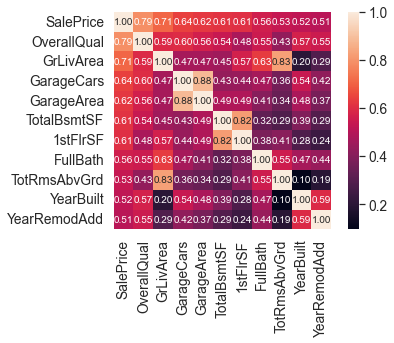

In [6]:
k = 11
corrmat = data.corr()
columns = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data[columns].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=columns.values, xticklabels=columns.values)
plt.show()

### Kurtosis, Asimetria y Gráfico de las 11 variables con mayor correlación

SalePrice :  Kurtosis: 6.509812011089439 Asimetría: 1.880940746034036 

OverallQual :  Kurtosis: 0.091856548449611 Asimetría: 0.2167209765258641 

GrLivArea :  Kurtosis: 4.874265760253215 Asimetría: 1.365155954773434 

GarageCars :  Kurtosis: 0.2161348715110729 Asimetría: -0.34219689543081294 

GarageArea :  Kurtosis: 0.9098227950882034 Asimetría: 0.1797959420587727 

TotalBsmtSF :  Kurtosis: 13.201041630635025 Asimetría: 1.522688086978629 

1stFlrSF :  Kurtosis: 5.722076026587489 Asimetría: 1.3753417421837937 

FullBath :  Kurtosis: -0.8582173323828637 Asimetría: 0.0365239844325461 

TotRmsAbvGrd :  Kurtosis: 0.8736413737415689 Asimetría: 0.6756457673102017 

YearBuilt :  Kurtosis: -0.44215484565294716 Asimetría: -0.612830724202899 

YearRemodAdd :  Kurtosis: -1.2719991404772555 Asimetría: -0.5030444967597948 



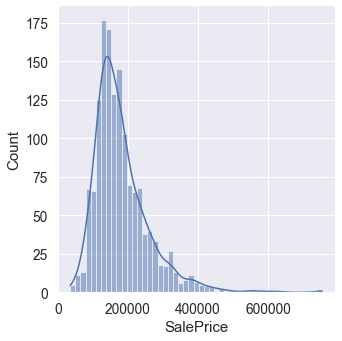

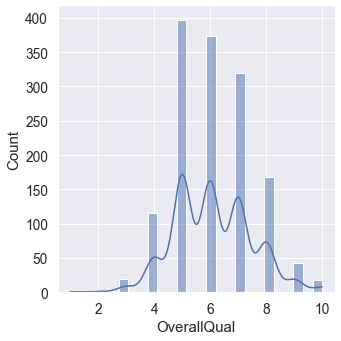

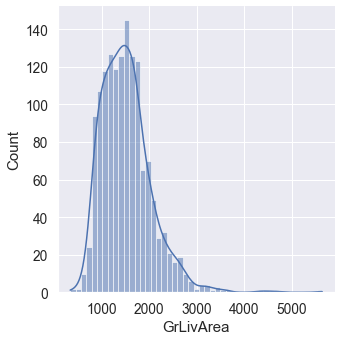

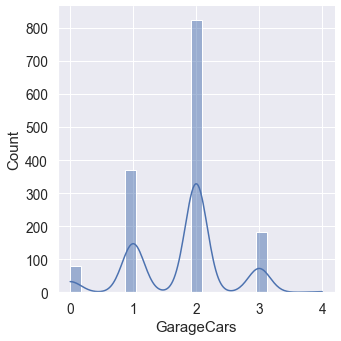

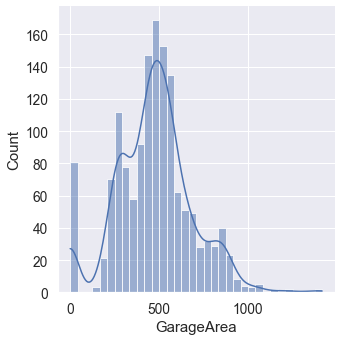

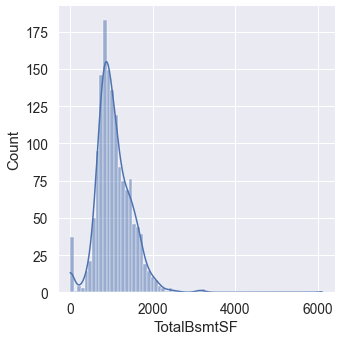

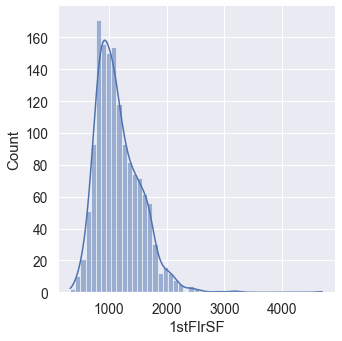

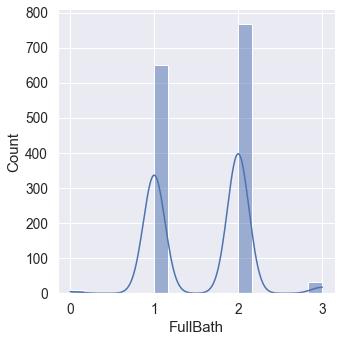

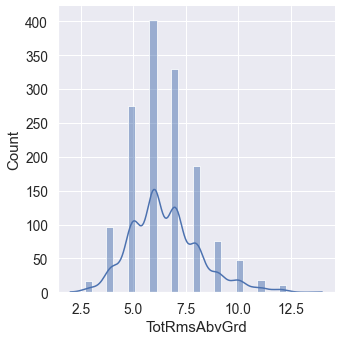

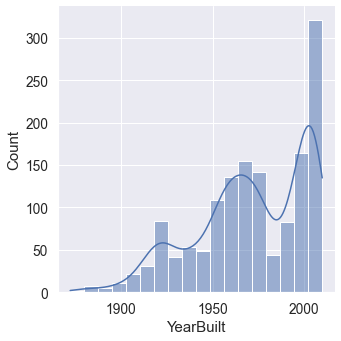

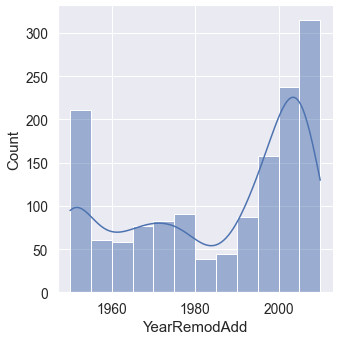

In [15]:
for var in columns:
    localData = data[var].dropna(how='all', axis=0)
  
    sns.displot(localData, kde=True)

    print( var, ':', ' Kurtosis:', stats.kurtosis(localData), 'Asimetría:', stats.skew(localData), '\n')

### Gráfico de pares de las 11 variables cuantitativas con mayor correlación

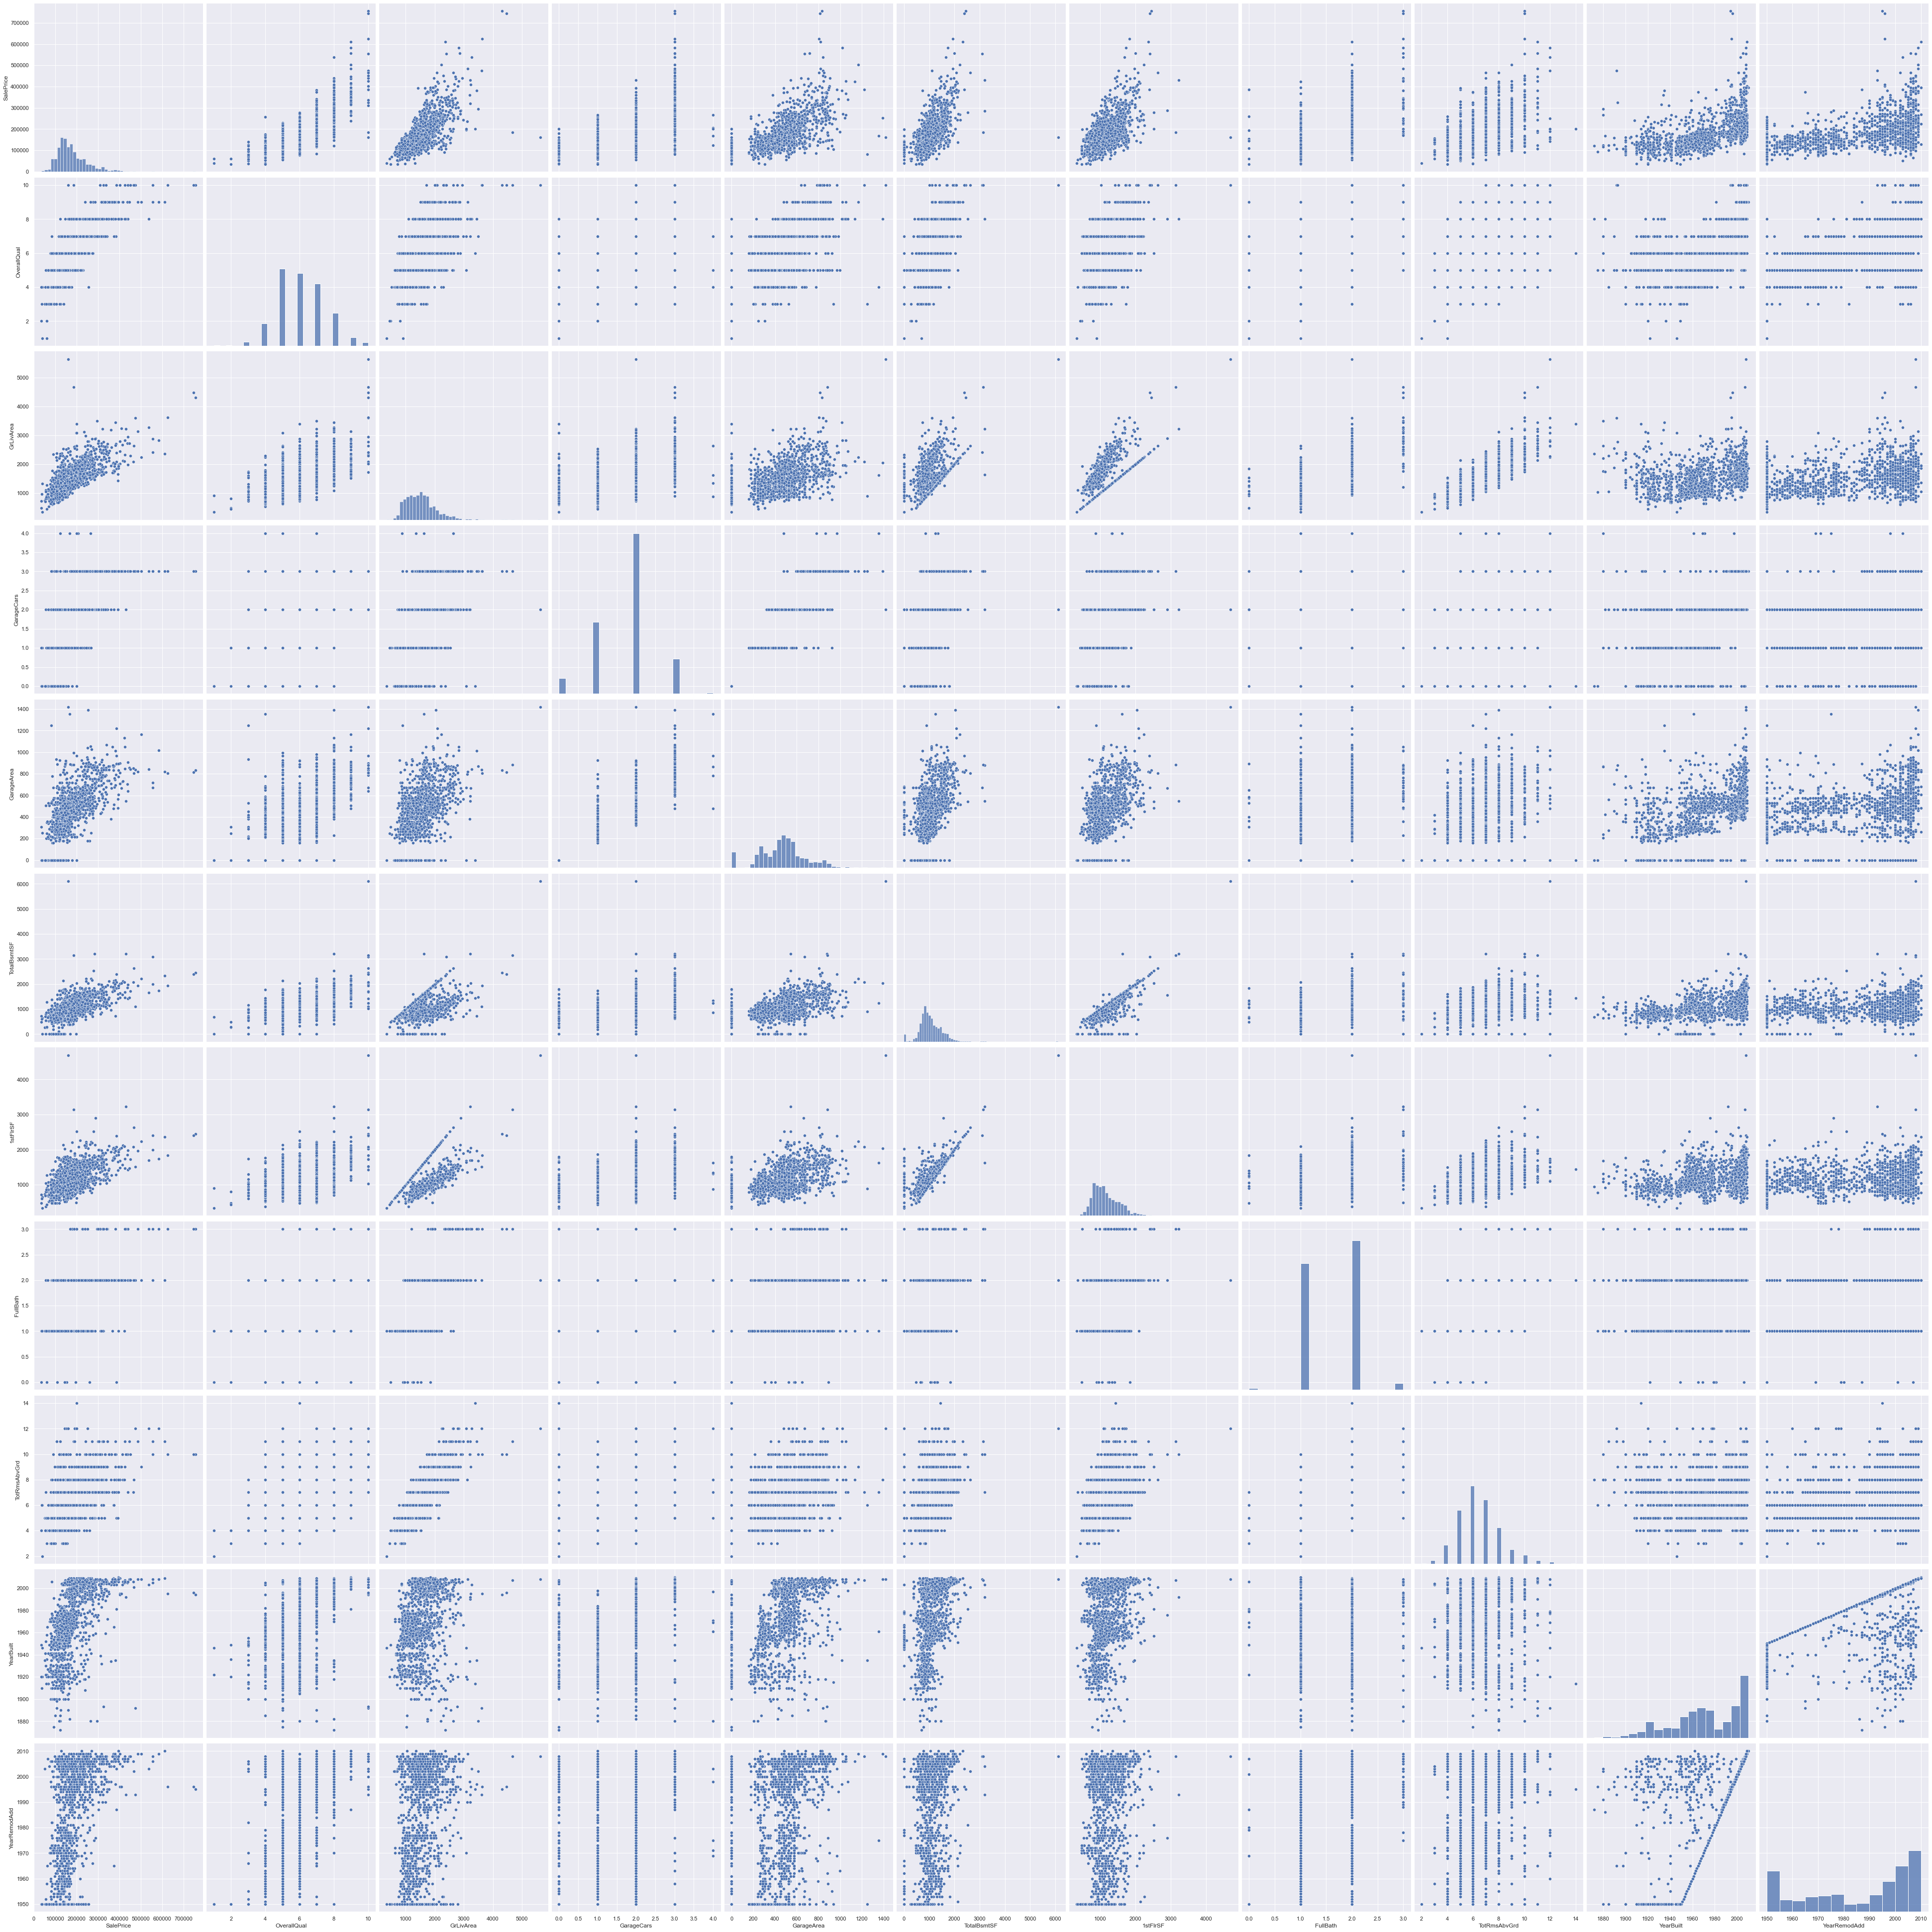

In [12]:
sns.set()
sns.pairplot(data[columns], height= 5)
plt.show()


### Gráficos de barras de las variables cualitativas

Id


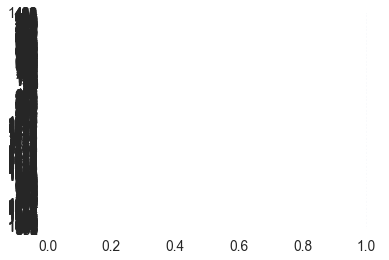

<Figure size 1440x360 with 0 Axes>

MSSubClass


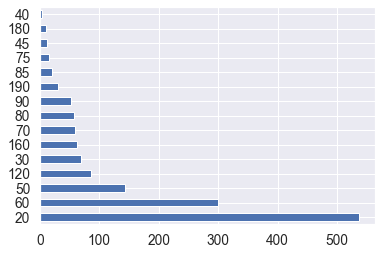

<Figure size 1440x360 with 0 Axes>

MSZoning


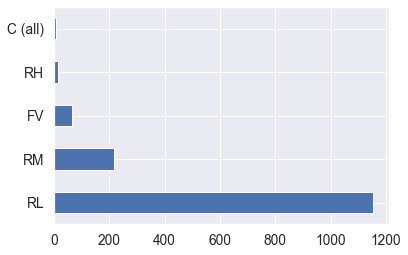

<Figure size 1440x360 with 0 Axes>

Street


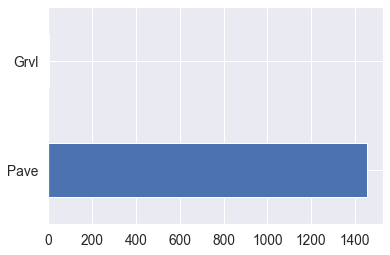

<Figure size 1440x360 with 0 Axes>

Alley


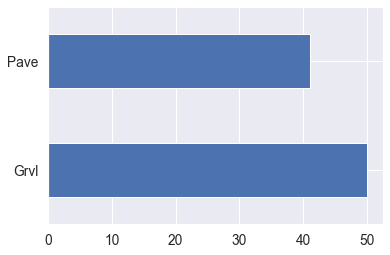

<Figure size 1440x360 with 0 Axes>

LotShape


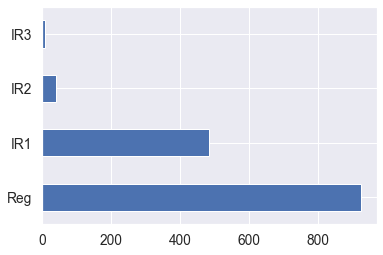

<Figure size 1440x360 with 0 Axes>

LandContour


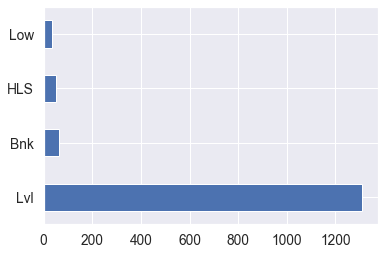

<Figure size 1440x360 with 0 Axes>

Utilities


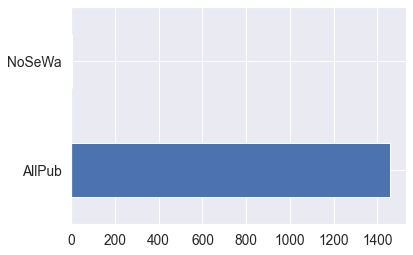

<Figure size 1440x360 with 0 Axes>

LotConfig


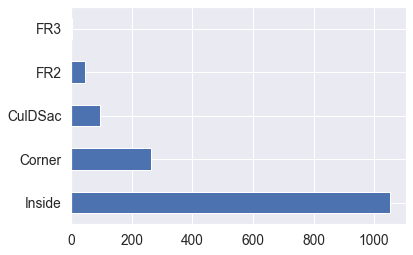

<Figure size 1440x360 with 0 Axes>

LandSlope


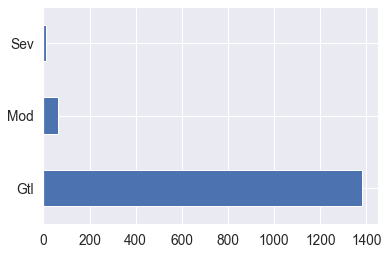

<Figure size 1440x360 with 0 Axes>

Neighborhood


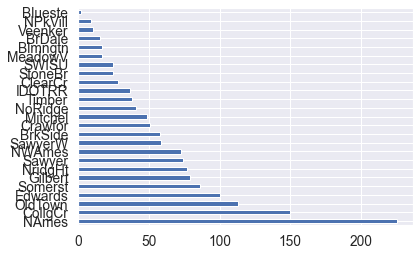

<Figure size 1440x360 with 0 Axes>

Condition1


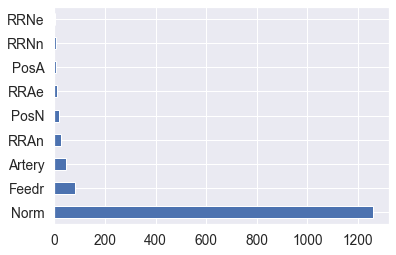

<Figure size 1440x360 with 0 Axes>

Condition2


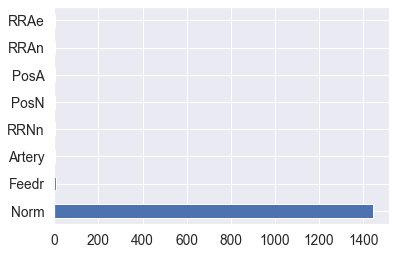

<Figure size 1440x360 with 0 Axes>

BldgType


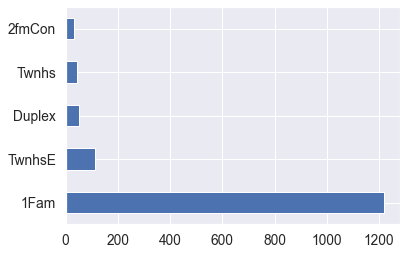

<Figure size 1440x360 with 0 Axes>

HouseStyle


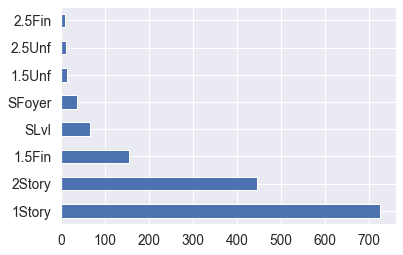

<Figure size 1440x360 with 0 Axes>

OverallQual


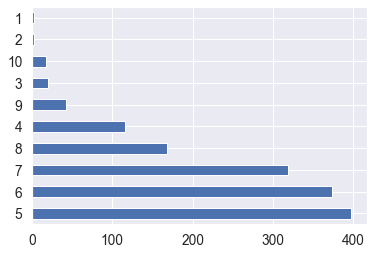

<Figure size 1440x360 with 0 Axes>

OverallCond


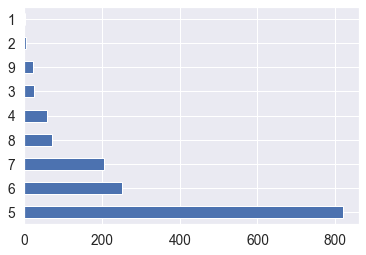

<Figure size 1440x360 with 0 Axes>

YearBuilt


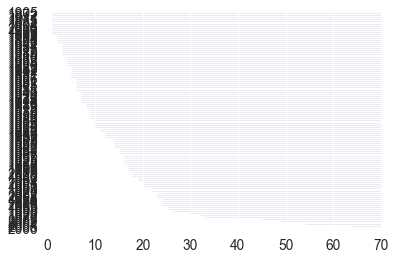

<Figure size 1440x360 with 0 Axes>

YearRemodAdd


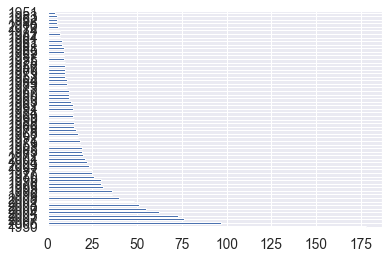

<Figure size 1440x360 with 0 Axes>

RoofStyle


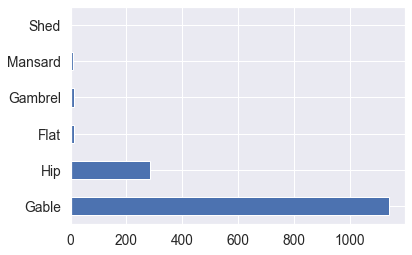

<Figure size 1440x360 with 0 Axes>

RoofMatl


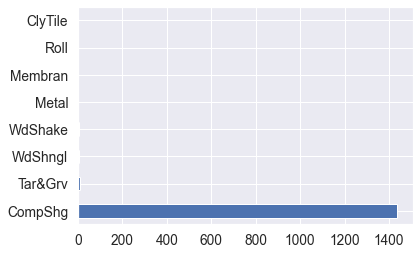

<Figure size 1440x360 with 0 Axes>

Exterior1st


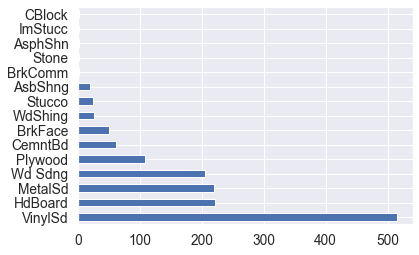

<Figure size 1440x360 with 0 Axes>

Exterior2nd


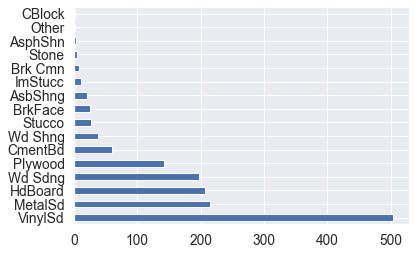

<Figure size 1440x360 with 0 Axes>

MasVnrType


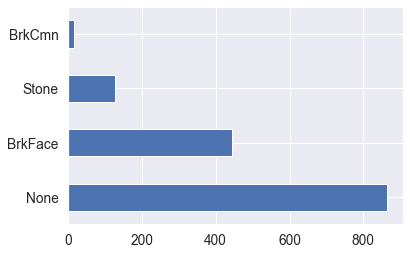

<Figure size 1440x360 with 0 Axes>

ExterQual


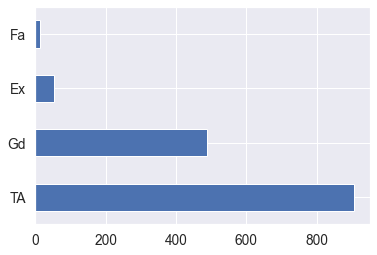

<Figure size 1440x360 with 0 Axes>

ExterCond


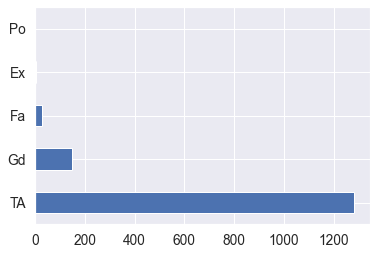

<Figure size 1440x360 with 0 Axes>

Foundation


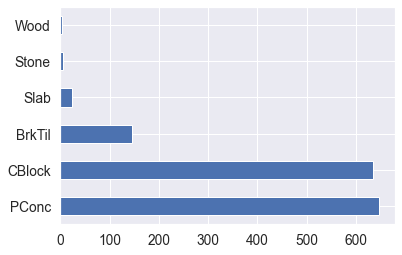

<Figure size 1440x360 with 0 Axes>

BsmtQual


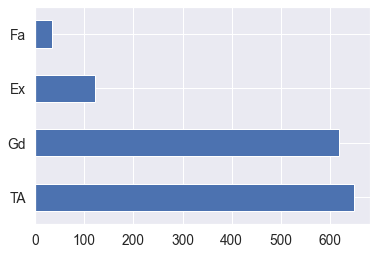

<Figure size 1440x360 with 0 Axes>

BsmtCond


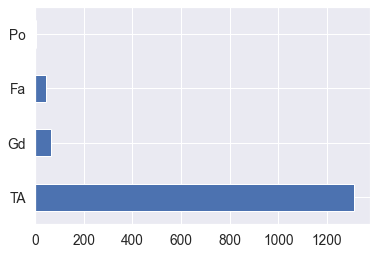

<Figure size 1440x360 with 0 Axes>

BsmtExposure


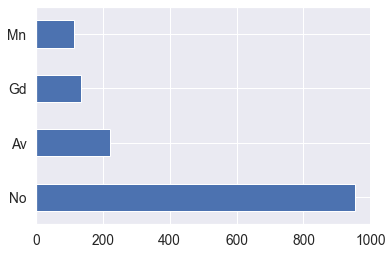

<Figure size 1440x360 with 0 Axes>

BsmtFinType1


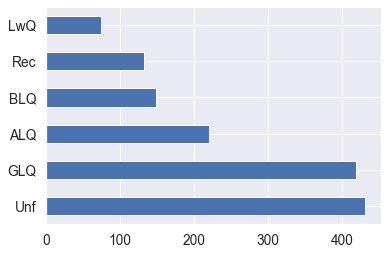

<Figure size 1440x360 with 0 Axes>

BsmtFinType2


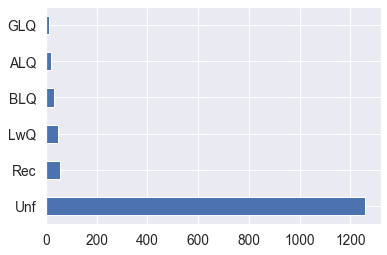

<Figure size 1440x360 with 0 Axes>

Heating


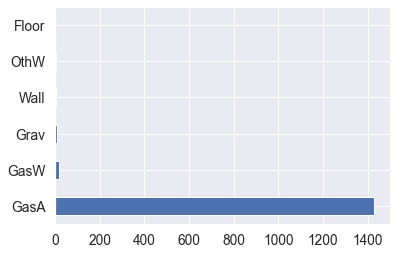

<Figure size 1440x360 with 0 Axes>

HeatingQC


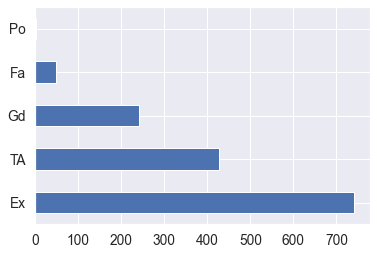

<Figure size 1440x360 with 0 Axes>

CentralAir


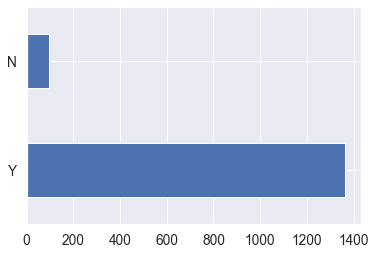

<Figure size 1440x360 with 0 Axes>

Electrical


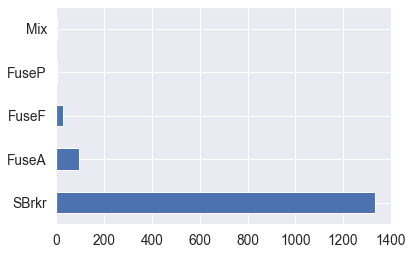

<Figure size 1440x360 with 0 Axes>

MoSold


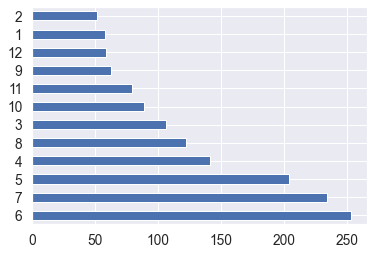

<Figure size 1440x360 with 0 Axes>

YrSold


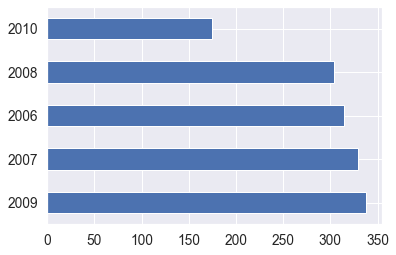

<Figure size 1440x360 with 0 Axes>

SaleType


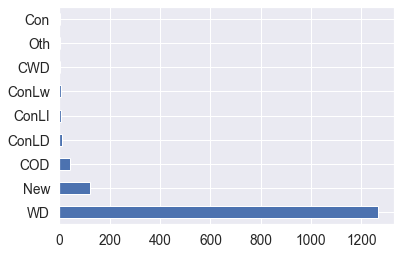

<Figure size 1440x360 with 0 Axes>

SaleCondition


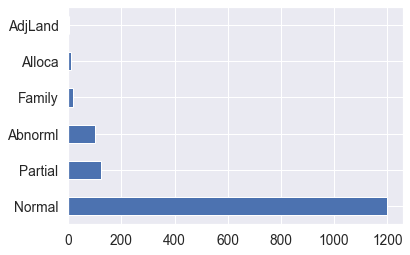

<Figure size 1440x360 with 0 Axes>

PoolQC


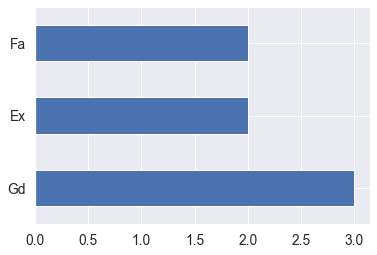

<Figure size 1440x360 with 0 Axes>

Fence


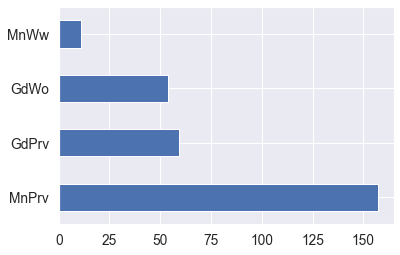

<Figure size 1440x360 with 0 Axes>

Functional


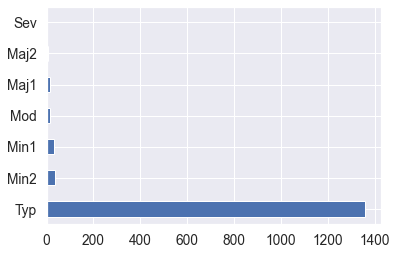

<Figure size 1440x360 with 0 Axes>

MiscFeature


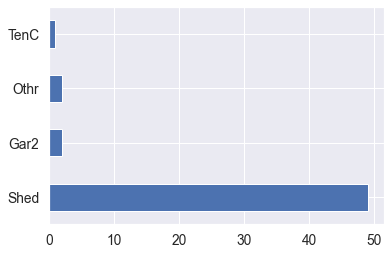

<Figure size 1440x360 with 0 Axes>

GarageQual


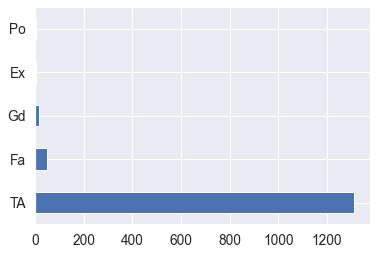

<Figure size 1440x360 with 0 Axes>

GarageCond


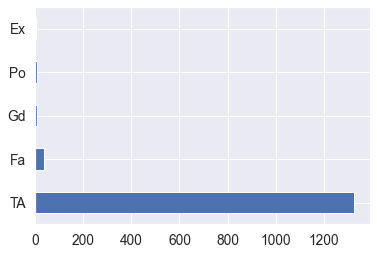

<Figure size 1440x360 with 0 Axes>

PavedDrive


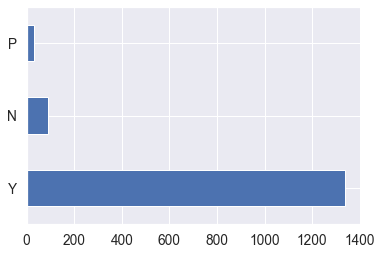

<Figure size 1440x360 with 0 Axes>

FireplaceQu


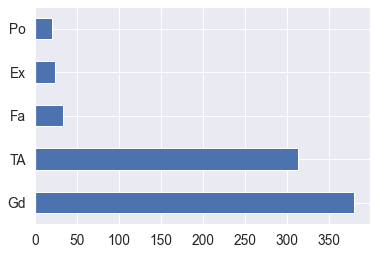

<Figure size 1440x360 with 0 Axes>

GarageType


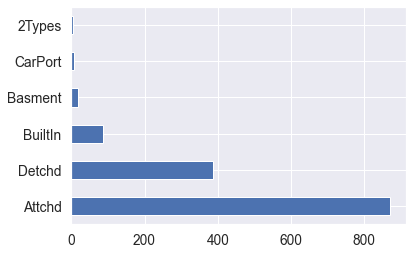

<Figure size 1440x360 with 0 Axes>

GarageYrBlt


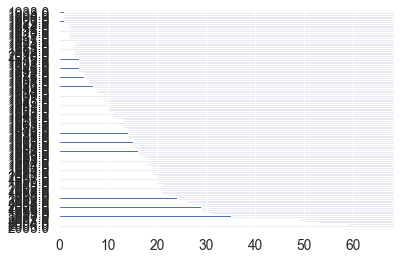

<Figure size 1440x360 with 0 Axes>

GarageFinish


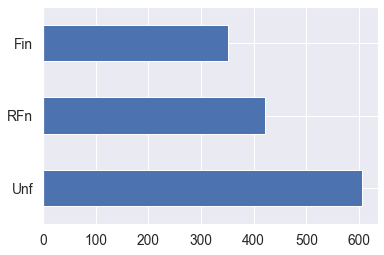

<Figure size 1440x360 with 0 Axes>

KitchenQual


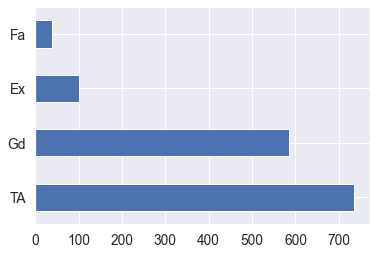

<Figure size 1440x360 with 0 Axes>

In [16]:
#Variables cualitativas
for var in quali:
  data[var].value_counts().plot(kind='barh')
  plt.figure(figsize=(20,5))
  print(var)
  plt.show()

### Kurtosis, Asimetria y Gráfico de las otras variables cuantitativas

In [ ]:
for var in quant:
  if var not in columns:
    localData = data[var].dropna(how='all', axis=0)
  
    sns.displot(localData, kde=True)

    print( var, ':', ' Kurtosis:', stats.kurtosis(localData), 'Asimetría:', stats.skew(localData), '\n')

### Análisis PCA

De acuerdo con la matriz de correlación presentada anteriormente, se observan 3 fenómenos importantes:
-Dentro de las 11 variables con mayor correlación, hay correlación alta y baja
-La correlación alta por lo general es entre variables que se conectan por lo que miden (garage con cantidad de carros)
-La correlación baja se da entre variables de tamaño vs año.

####  índice  KMO  y  el  test  de  esfericidad  de  Bartlett